In [ ]:
#!pip install -q kaggle


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [ ]:
!kaggle datasets download -d sumn2u/garbage-classification-v2

 99% 867M/876M [00:06<00:00, 151MB/s]
100% 876M/876M [00:06<00:00, 131MB/s]


In [ ]:
!mkdir garbage
!unzip garbage-classification-v2.zip -d garbage

Streaming output truncated to the last 5000 lines.
  inflating: garbage/Garbage Classification/paper/paper_0970.jpg  
  inflating: garbage/Garbage Classification/paper/paper_0971.jpg  
  inflating: garbage/Garbage Classification/paper/paper_0972.jpg  
  inflating: garbage/Garbage Classification/paper/paper_0973.jpg  
  inflating: garbage/Garbage Classification/paper/paper_0974.jpg  
  inflating: garbage/Garbage Classification/paper/paper_0975.jpg  
  inflating: garbage/Garbage Classification/paper/paper_0976.jpg  
  inflating: garbage/Garbage Classification/paper/paper_0977.jpg  
  inflating: garbage/Garbage Classification/paper/paper_0978.jpg  
  inflating: garbage/Garbage Classification/paper/paper_0979.jpg  
  inflating: garbage/Garbage Classification/paper/paper_0980.jpg  
  inflating: garbage/Garbage Classification/paper/paper_0981.jpg  
  inflating: garbage/Garbage Classification/paper/paper_0982.jpg  
  inflating: garbage/Garbage Classification/paper/paper_0983.jpg  
  inflating

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir test_1
!mv /content/garbage/Garbage\ Classification/battery test_1
!mv /content/garbage/Garbage\ Classification/glass test_1
!mv /content/garbage/Garbage\ Classification/plastic test_1
#https://stackoverflow.com/questions/53074712/how-to-split-folder-of-images-into-test-training-validation-sets-with-stratified

In [ ]:
import splitfolders
splitfolders.ratio('test_1', output="output", seed=1337, ratio=(0.5, 0.25,0.25))

Copying files: 6984 files [00:03, 1937.47 files/s]


# -----Solving-----

In [ ]:
from tensorflow.python.ops.math_ops import truncate_mod
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy

datagen = ImageDataGenerator()
#https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
train_generator = datagen.flow_from_directory(
    directory=r"/content/output/train",
    target_size=(50, 50),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True, #інакше в batch-ах однакові лейбли будуть
    seed=42
)

valid_generator = datagen.flow_from_directory(
    directory=r"/content/output/val",
    target_size=(50, 50),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_generator = datagen.flow_from_directory(
    directory=r"/content/output/test",
    target_size=(50, 50),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=True,
    seed=42
)


Found 3491 images belonging to 3 classes.
Found 1745 images belonging to 3 classes.
Found 1748 images belonging to 3 classes.


In [ ]:
model = tf.keras.models.Sequential([layers.Conv2D(64, (3, 3), activation = "relu", input_shape = (50, 50, 3)),
                                   layers.MaxPooling2D(2, 2),
                                   layers.Conv2D(64, (3, 3), activation = "relu"),
                                   layers.MaxPooling2D(2, 2),
                                   layers.Flatten(),
                                   layers.Dense(50, activation="relu"),
                                   layers.Dense(3, activation = "softmax")])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model.fit_generator(generator = train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 10,
                    )
print("Evaluating:")
model.evaluate_generator(generator = valid_generator, steps=STEP_SIZE_VALID)
#model.save("trash_recognition.h5")

In [ ]:
model = keras.models.load_model("/content/trash_recognition_2.h5")

In [ ]:
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model_old.evaluate_generator(generator = valid_generator, steps=STEP_SIZE_VALID)


<ipython-input-35-5807f10d81e0>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model_old.evaluate_generator(generator = valid_generator, steps=STEP_SIZE_VALID)
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[0.7859466671943665, 0.6851851940155029]

In [ ]:
model.metrics_names

['loss', 'accuracy']

In [ ]:
def test_image(file_name:str):
  import matplotlib.pyplot as plt
  image = Image.open(file_name)
  image = image.resize((50, 50))
  matrix = numpy.asarray(image)
  plt.imshow(matrix)
  matrix = matrix.reshape((1, 50, 50, 3))
  #print(numpy.shape(matrix))
  #matrix_multi = numpy.ndarray(shape = (50, 50, 3), buffer = matrix)
  classifications = model.predict(matrix)
  print(classifications[0])
  predicted_class_index=numpy.argmax(classifications,axis=1)
  vise_versa_dict = dict()
  for (k,v) in train_generator.class_indices.items():
    vise_versa_dict[v] = k
  predictions = [vise_versa_dict[k] for k in predicted_class_index]
  print(train_generator.class_indices)
  print(predictions)

In [ ]:
import pandas as pd
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

predicted_class_indices=numpy.argmax(pred,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
print(numpy.shape(predictions))


filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

   1/1748 [..............................] - ETA: 3:17

<ipython-input-29-98d913d8d528>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=model.predict_generator(test_generator,


1748/1748 [==============================] - 21s 12ms/step
(1748,)


1/1 [==============================] - 0s 496ms/step
[9.9997663e-01 4.3940153e-07 2.2905970e-05]
{'battery': 0, 'glass': 1, 'plastic': 2}
['battery']


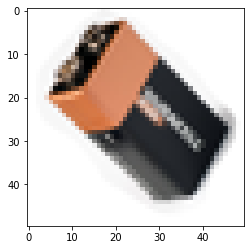

In [ ]:
test_image("batt_1.jpg")

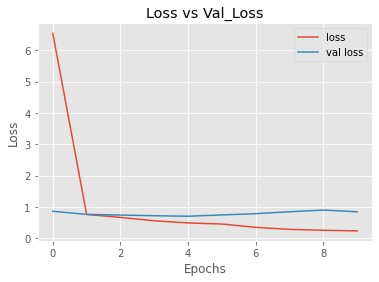

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model.save("trash_recognition_2.h5")